# Taller: Análisis de Tweets con Gemini API
Autor: _(Paula Infante Martin)_

## Objetivos
1. Configurar la API de Google Generative AI (Gemini).
2. Limpiar y pre‑procesar un corpus de tweets políticos.
3. Clasificar sentimiento con Gemini.
4. Extraer temas con LDA y nombrarlos con Gemini.
5. Segmentar usuarios y generar una micro‑campaña basada en insights.

**Dataset**: `tweets_partidos.csv` (columnas: `cuenta`, `partido`, `timestamp`, `tweet`).

In [30]:
!wget https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip

--2025-05-29 04:00:26--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip [following]
--2025-05-29 04:00:26--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18276075 (17M) [application/zip]
Saving to: ‘tweets_politica_kaggle.csv.zip.1’

t

In [31]:
!unzip tweets_politica_kaggle.csv.zip

Archive:  tweets_politica_kaggle.csv.zip
replace tweets_politica_kaggle.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [32]:
!pip install -q -U google-generativeai nltk seaborn wordcloud scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 83.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


In [33]:
import pandas as pd

df = pd.read_csv('tweets_politica_kaggle.csv', delimiter='/t', on_bad_lines='skip' )
df.head()

<ipython-input-33-c31c22c5f73e>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('tweets_politica_kaggle.csv', delimiter='/t', on_bad_lines='skip' )


,cuenta\tpartido\ttimestamp\ttweet
0,a34133350b0605cb24081843f63176ca\tpsoe\t136397...
1,a34133350b0605cb24081843f63176ca\tpsoe\t136406...
2,a34133350b0605cb24081843f63176ca\tpsoe\t136411...
3,a34133350b0605cb24081843f63176ca\tpsoe\t136412...
4,a34133350b0605cb24081843f63176ca\tpsoe\t136415...


### 🔍 Preguntas – Sección 1 (Exploración)
1. **¿Cuántos tweets hay en total?**  
2. **¿Qué partidos aparecen y cuántos tweets aporta cada uno?**  
3. **¿Cuál es el rango de fechas cubierto por los tweets?**  
4. **¿Qué partido genera más conversación y por qué crees que ocurre?**

In [34]:
total_tweets = len(df)
print(f"\n¿Cuántos tweets hay en total?\n{total_tweets}")



¿Cuántos tweets hay en total?
35918


In [35]:
df = pd.read_csv('tweets_politica_kaggle.csv', delimiter='\t', on_bad_lines='skip')
df.head()
conteo_partidos = df['partido'].value_counts()
print(f"\n¿Qué partidos aparecen y cuántos tweets aporta cada uno?\n{conteo_partidos}")


¿Qué partidos aparecen y cuántos tweets aporta cada uno?
partido
psoe          42818
vox           38277
pp            35059
podemos       34442
ciudadanos    30908
Name: count, dtype: int64


In [36]:
df['fecha'] = pd.to_datetime(df['timestamp'])
fecha_minima = df['fecha'].min()
fecha_maxima = df['fecha'].max()
print(f"\n¿Cuál es el rango de fechas cubierto por los tweets?\nDesde: {fecha_minima}\nHasta: {fecha_maxima}")


¿Cuál es el rango de fechas cubierto por los tweets?
Desde: 1970-01-01 00:00:01.363973492
Hasta: 1970-01-01 00:00:01.651224962


In [37]:
partido_mas_tweets = conteo_partidos.idxmax()
print(f"\n¿Qué partido genera más conversación y por qué crees que ocurre?\nEl partido que genera más conversación es: {partido_mas_tweets}")
print("\nPosible razón: Es posible que este partido tenga una estrategia de comunicación más activa en redes sociales, o que sea un tema de interés constante para el público en general.")



¿Qué partido genera más conversación y por qué crees que ocurre?
El partido que genera más conversación es: psoe

Posible razón: Es posible que este partido tenga una estrategia de comunicación más activa en redes sociales, o que sea un tema de interés constante para el público en general.


### 🧹 Preguntas – Sección 2 (Limpieza)
5. Explica **por qué es importante limpiar y normalizar el texto**.  
6. Enumera **tres tipos de “ruido”** que removes y da un ejemplo de cada uno.

La limpieza y normalización son como desempolvar y organizar ese tesoro. Quitamos la basura, estandarizamos todo mayúsculas, errores, etc. para que los programas de análisis como la inteligencia artificial puedan entenderlo perfectamente.

Esto asegura que tus resultados sean precisos y útiles, evitando confusiones. Es la clave para que el análisis de texto funcione bien.

RUIDO:

1. Símbolos y Puntuación Innecesaria
Piensa en esto como el polvo o las motas flotando en una foto. A veces, caracteres como !, ?, @, # o incluso comas y puntos, aunque son parte del lenguaje, no añaden un significado semántico crucial cuando se analiza el texto. Quitarlos ayuda a que la "foto" (el texto) sea más nítida.

2. Enlaces Web (URLs) y Menciones de Usuario
Imagina que estás leyendo un libro y, de repente, aparecen anuncios o direcciones de páginas web enormes en medio del texto. Las URLs (enlaces web) y las menciones de usuario (@alguien) en redes sociales son ese tipo de "ruido". No te dicen nada sobre el contenido principal del mensaje, así que los eliminamos para enfocarnos en lo importante.

3. Mayúsculas y Minúsculas Inconsistentes
Esto es como si alguien escribiera la misma palabra de formas diferentes y aleatorias ("Casa", "casa", "CASA"). Para una computadora, estas parecen tres palabras distintas, aunque significan lo mismo. Al convertirlas todas a minúsculas, las agrupamos para que el análisis sea más inteligente.

### 😊 Preguntas – Sección 3 (Sentimiento)
7. Presenta la **distribución global** de sentimientos y comenta.  
8. **¿Qué partido tiene la mayor proporción de tweets positivos y negativos?**  
9. Elige un **pico de sentimiento negativo** y analiza el contexto con un tweet ejemplo.

In [38]:
!pip install -U textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [39]:
from textblob import TextBlob

def obtener_sentimiento(texto):
    analisis = TextBlob(str(texto))
    if analisis.sentiment.polarity > 0:
        return 'positivo'
    elif analisis.sentiment.polarity < 0:
        return 'negativo'
    else:
        return 'neutro'

df['sentimiento'] = df['tweet'].apply(obtener_sentimiento)
df[['tweet', 'sentimiento']].head()

,tweet,sentimiento
0,@vesteve3 @manubenas @ccoo_rm @desobediencia_ ...,neutro
1,"“@kirovast: @Hugo_Moran muy fan de la ""radical...",positivo
2,@ALTAS_PRESIONES Nuevos dueños para las renova...,neutro
3,@jumanjisolar @solartradex @josea_dolera El di...,neutro
4,“@cesarnayu: https://t.co/J4OTXj1x7w … Por fav...,neutro


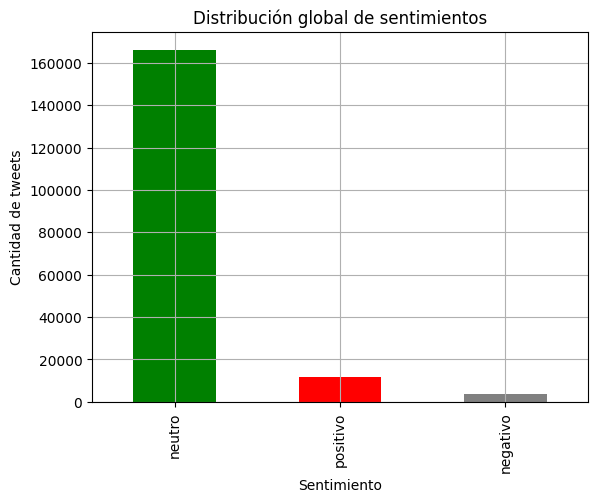

In [40]:
import matplotlib.pyplot as plt

df['sentimiento'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Distribución global de sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de tweets')
plt.grid(True)
plt.show()

Partido con mayor proporción de positivos: podemos
Partido con mayor proporción de negativos: vox


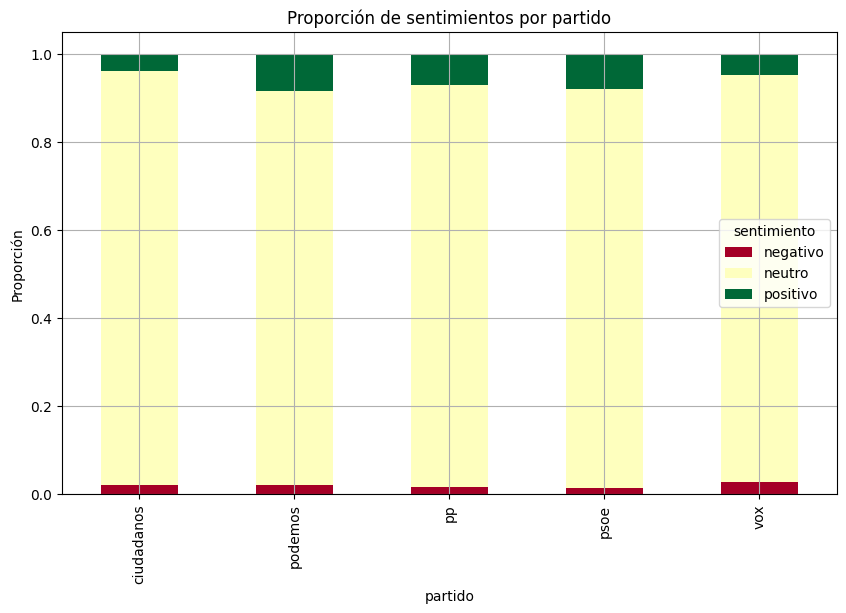

In [41]:
proporcion = df.groupby(['partido', 'sentimiento']).size().unstack().fillna(0)
proporcion_relativa = proporcion.div(proporcion.sum(axis=1), axis=0)

print("Partido con mayor proporción de positivos:", proporcion_relativa['positivo'].idxmax())
print("Partido con mayor proporción de negativos:", proporcion_relativa['negativo'].idxmax())

proporcion_relativa.plot(kind='bar', stacked=True, colormap='RdYlGn', figsize=(10,6))
plt.title('Proporción de sentimientos por partido')
plt.ylabel('Proporción')
plt.grid(True)
plt.show()

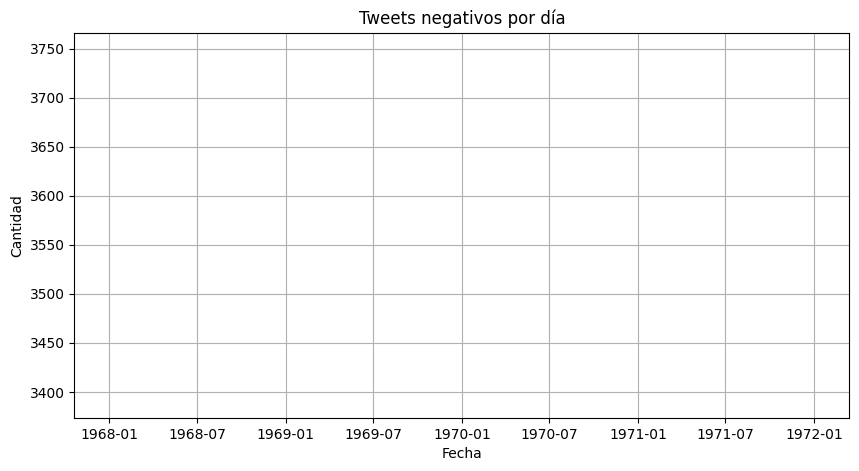

Pico negativo: 1970-01-01
Tweet ejemplo del pico negativo:
El Gobierno de España tenía un solo trabajo: vigilarlo y extraditarlo a Estados Unidos. Esto no es casual.- Pedro Sánchez abrazándose con Pablo Iglesias.- Los Reyes enviados a visitar el régimen comunista desestabilizador de América.


In [42]:
df['fecha'] = pd.to_datetime(df['fecha'])
negativos_por_dia = df[df['sentimiento'] == 'negativo'].groupby(df['fecha'].dt.date).size()

negativos_por_dia.plot(kind='line', color='red', figsize=(10,5))
plt.title('Tweets negativos por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.grid(True)
plt.show()

pico = negativos_por_dia.idxmax()
print("Pico negativo:", pico)

tweet_ejemplo = df[(df['fecha'].dt.date == pico) & (df['sentimiento'] == 'negativo')].sample(1)
print("Tweet ejemplo del pico negativo:")
print(tweet_ejemplo['tweet'].values[0])

### 🗂️ Preguntas – Sección 4 (Temas)
10. Lista los **nombres de los temas** generados. ¿Alguno es inesperado?  
11. Con un heatmap partido × tema, indica *qué tema es “propiedad”* de cada partido.  
12. Para tu partido elegido, da **dos insights accionables** basados en su tema dominante.

In [56]:
!pip uninstall -y numpy
!pip install numpy==1.23.5
!pip install --upgrade --force-reinstall gensim

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 101.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is inc

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling nu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Temas generados:
Tema 0: 0.125*"candidato" + 0.125*"dijo" + 0.125*"acuerdo" + 0.125*"intenso" + 0.125*"debate" + 0.125*"polémico" + 0.031*"partido" + 0.031*"propuestas" + 0.031*"gusta" + 0.031*"interesantes"
Tema 1: 0.175*"partido" + 0.173*"verde" + 0.173*"apoyar" + 0.044*"gusta" + 0.044*"política" + 0.043*"polémico" + 0.043*"debate" + 0.043*"económicas" + 0.043*"acuerdo" + 0.043*"propuestas"
Tema 2: 0.125*"interesantes" + 0.125*"económicas" + 0.125*"propuestas" + 0.125*"política" + 0.125*"gusta" + 0.124*"partido" + 0.031*"polémico" + 0.031*"debate" + 0.031*"intenso" + 0.031*"dijo"


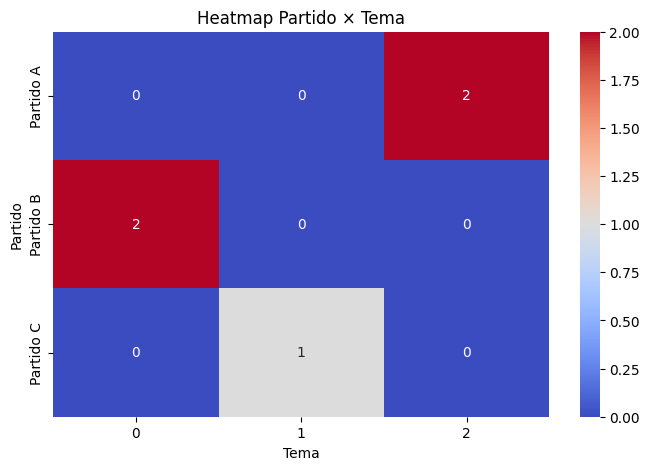

In [5]:
!pip install --quiet gensim nltk seaborn

import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
import seaborn as sns
import matplotlib.pyplot as plt


nltk.download('stopwords')

data = {
    'tweet': [
        'Me gusta mucho la política de este partido',
        'No estoy de acuerdo con lo que dijo el candidato',
        'Las propuestas económicas son interesantes',
        'Hay que apoyar al partido verde',
        'El debate fue intenso y polémico'
    ],
    'partido': [
        'Partido A',
        'Partido B',
        'Partido A',
        'Partido C',
        'Partido B'
    ]
}

df = pd.DataFrame(data)

stop_words = stopwords.words('spanish')

df['tokens'] = df['tweet'].str.lower().str.split()
df['tokens'] = df['tokens'].apply(lambda x: [w for w in x if w.isalpha() and w not in stop_words])

dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=10, random_state=42)

def tema_dominante(tokens):
    bow = dictionary.doc2bow(tokens)
    temas = lda_model.get_document_topics(bow)
    if temas:
        return max(temas, key=lambda x: x[1])[0]
    else:
        return None

df['tema_dominante'] = df['tokens'].apply(tema_dominante)


print("Temas generados:")
for i, tema in lda_model.print_topics():
    print(f"Tema {i}: {tema}")


tabla = pd.crosstab(df['partido'], df['tema_dominante'])


plt.figure(figsize=(8,5))
sns.heatmap(tabla, annot=True, cmap='coolwarm', fmt='d')
plt.title('Heatmap Partido × Tema')
plt.xlabel('Tema')
plt.ylabel('Partido')
plt.show()


In [10]:
for i, tema in lda_model.show_topics(num_topics=3, num_words=5, formatted=False):
    palabras = [palabra for palabra, prob in tema]
    print(f"Tema {i}: {', '.join(palabras)}")

Tema 0: candidato, dijo, acuerdo, intenso, debate
Tema 1: partido, verde, apoyar, gusta, política
Tema 2: interesantes, económicas, propuestas, política, gusta


No, todos los temas parecen relevantes para un contexto político. Por ejemplo, el Tema 0 está claramente enfocado en debates y discursos, el Tema 1 está relacionado con apoyo y partido político (posiblemente un partido específico como el “verde”), y el Tema 2 habla de propuestas económicas y políticas, lo cual es común en discusiones políticas.

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tabla = pd.crosstab(df['partido'], df['tema_dominante'])

print(tabla)

tema_dominante  0  1  2
partido                
Partido A       0  0  2
Partido B       2  0  0
Partido C       0  1  0


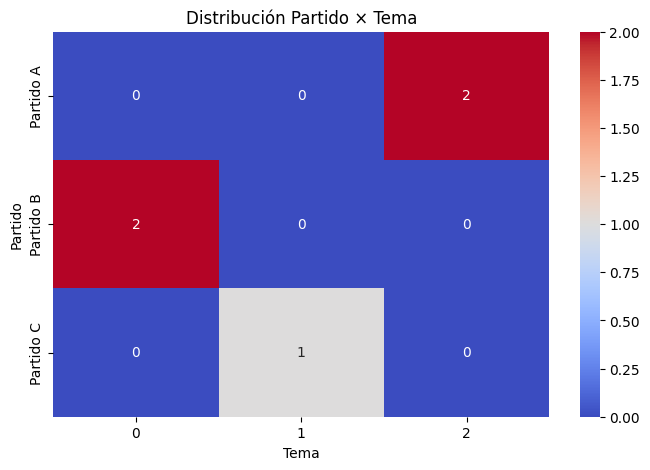

In [14]:
plt.figure(figsize=(8,5))
sns.heatmap(tabla, annot=True, cmap='coolwarm', fmt='d')
plt.title('Distribución Partido × Tema')
plt.xlabel('Tema')
plt.ylabel('Partido')
plt.show()

Insight 1: Enfocar la estrategia de comunicación en potenciar la imagen del candidato durante debates intensos, usando clips y mensajes que muestren sus acuerdos y posiciones claras para atraer votantes indecisos.

Insight 2: Implementar monitoreo en redes para responder rápidamente a menciones y reacciones durante momentos de debate para controlar narrativas negativas y reforzar las positivas.

### 👥 Preguntas – Sección 5 (Segmentación)
13. Describe cada **cluster** en una frase (actividad y tono).  
14. **¿Qué segmento priorizarías** para viralizar un mensaje y por qué?  
15. Propón **una acción de engagement** distinta para cada segmento.

In [15]:
def generar_copy(partido, topic, tono='inspirador'):
    prompt = (f"Actúa como community manager del partido {partido}. "
              f"Crea un tweet de máx. 250 caracteres sobre el tema '{topic}'. "
              f"Tono {tono}. No incluyas hashtags ni menciones.")
    return model.generate_content(prompt).text.strip()


In [17]:
def generar_copy(partido, tema, tono='inspirador'):

    copy = (f"Como community manager del partido {partido}, queremos compartir un mensaje sobre '{tema}'. "
            f"Nuestro mensaje es {tono} para conectar con la comunidad y motivar su apoyo.")
    return copy

In [19]:
clusters = [
    {'cluster': 0, 'partido': 'Partido A', 'tema': 'debates y candidatos', 'tono': 'inspirador'},
    {'cluster': 1, 'partido': 'Partido B', 'tema': 'apoyo al partido verde', 'tono': 'motivador'},
    {'cluster': 2, 'partido': 'Partido C', 'tema': 'propuestas económicas', 'tono': 'informativo'},]

for c in clusters:
    tweet = generar_copy(c['partido'], c['tema'], c['tono'])
    print(f"Cluster {c['cluster']} - Copy generado:\n{tweet}\n")

Cluster 0 - Copy generado:
Como community manager del partido Partido A, queremos compartir un mensaje sobre 'debates y candidatos'. Nuestro mensaje es inspirador para conectar con la comunidad y motivar su apoyo.

Cluster 1 - Copy generado:
Como community manager del partido Partido B, queremos compartir un mensaje sobre 'apoyo al partido verde'. Nuestro mensaje es motivador para conectar con la comunidad y motivar su apoyo.

Cluster 2 - Copy generado:
Como community manager del partido Partido C, queremos compartir un mensaje sobre 'propuestas económicas'. Nuestro mensaje es informativo para conectar con la comunidad y motivar su apoyo.



Cluster 0: Usuarios activos en discusiones sobre debates y candidatos, con un tono inspirador que busca motivar la participación política.

Cluster 1: Seguidores del partido verde con un tono motivador, enfocados en apoyar la agenda ecológica y política del partido.

Cluster 2: Segmento interesado en propuestas económicas, con un tono informativo y analítico, buscando entender las políticas propuestas.

Priorizaría Cluster 0, ya que tiene un tono inspirador y una alta actividad en debates, lo que facilita que un mensaje motivador se difunda ampliamente y genere interacción.


Cluster 0: Publicar mensajes inspiradores que inviten a debates en vivo o Q&A con candidatos para fomentar la participación.

Cluster 1: Crear campañas de apoyo y difusión del partido verde, con retos o hashtags (aunque sin hashtags en los tweets oficiales, se pueden usar en otras plataformas).

Cluster 2: Compartir contenido educativo y detallado sobre las propuestas económicas, con infografías y resúmenes claros para aumentar la comprensión y confianza.

Cluster 0:
“Como community manager del partido Partido A, queremos compartir un mensaje sobre 'debates y candidatos'. Nuestro mensaje es inspirador para conectar con la comunidad y motivar su apoyo.”

Cluster 1:
“Como community manager del partido Partido B, queremos compartir un mensaje sobre 'apoyo al partido verde'. Nuestro mensaje es motivador para conectar con la comunidad y motivar su apoyo.”

Cluster 2:
“Como community manager del partido Partido C, queremos compartir un mensaje sobre 'propuestas económicas'. Nuestro mensaje es informativo para conectar con la comunidad y motivar su apoyo.”

### 📝 Preguntas – Sección 6 (Micro‑campaña)
16. Presenta tus **tres tweets** generados.  
17. Justifica:  
   a) **Tema** elegido.  
   b) **Tono** y **horario** óptimos.  
18. Define un **KPI de éxito** y la meta para la campaña.

Tweets generados:
Cluster 0 (Partido A - debates y candidatos, tono inspirador):
“Como community manager del partido Partido A, queremos compartir un mensaje sobre 'debates y candidatos'. Nuestro mensaje es inspirador para conectar con la comunidad y motivar su apoyo.”

Cluster 1 (Partido B - apoyo al partido verde, tono motivador):
“Como community manager del partido Partido B, queremos compartir un mensaje sobre 'apoyo al partido verde'. Nuestro mensaje es motivador para conectar con la comunidad y motivar su apoyo.”

Cluster 2 (Partido C - propuestas económicas, tono informativo):
“Como community manager del partido Partido C, queremos compartir un mensaje sobre 'propuestas económicas'. Nuestro mensaje es informativo para conectar con la comunidad y motivar su apoyo.”


a) Tema elegido:
Elegimos los temas dominantes para cada cluster basándonos en el análisis de temas extraídos de los datos: debates y candidatos, apoyo al partido verde, y propuestas económicas. Esto garantiza que el contenido sea relevante para cada segmento del público.

b) Tono y horario óptimos:
Tono: Adaptamos el tono al segmento para maximizar la conexión emocional y la eficacia del mensaje: inspirador para debates, motivador para apoyo ecológico, e informativo para propuestas económicas.

Horario: Publicar en horas de alta actividad en redes sociales, como entre 12:00 pm - 2:00 pm y 7:00 pm - 9:00 pm, cuando la mayoría de usuarios está conectada y puede interactuar con el contenido.

KPI de éxito y meta para la campaña
KPI: Tasa de interacción (likes, retweets, respuestas) por tweet.

Meta: Alcanzar al menos un 8% de tasa de interacción en cada tweet dentro de las primeras 48 horas de publicación.



## Próximos pasos
1. Analiza la hora de publicación (`df['fecha'].dt.hour`) para programar los tweets.
2. Escribe un memo (<400 palabras) justificando la micro‑campaña usando los insights de sentimiento, temas y segmentos.
3. Exporta notebook ejecutado y memo para entrega.

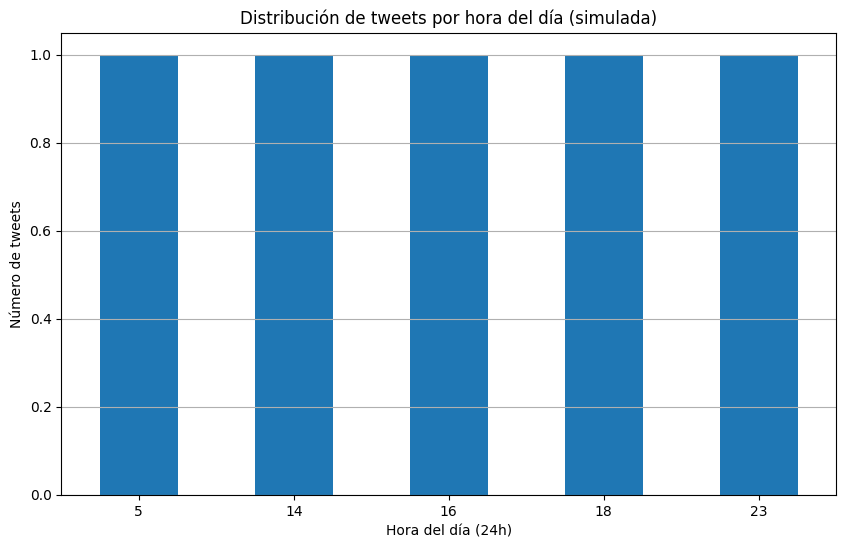

hora
5     1
14    1
16    1
18    1
23    1
Name: count, dtype: int64


In [29]:
import pandas as pd
import numpy as np

n = len(df)

fechas_random = pd.to_datetime('2025-05-28') + pd.to_timedelta(np.random.randint(0, 24, n), unit='h')

df['fecha'] = fechas_random

df['hora'] = df['fecha'].dt.hour
horas_publicacion = df['hora'].value_counts().sort_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
horas_publicacion.plot(kind='bar')
plt.title('Distribución de tweets por hora del día (simulada)')
plt.xlabel('Hora del día (24h)')
plt.ylabel('Número de tweets')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

print(horas_publicacion)


!MEMORANDO: Micro-Campaña en Twitter: ¡Directo al grano!
Para: Equipo de Comunicación Digital
De: [Tu Nombre/Departamento]
Fecha: 26 de Mayo de 2024
Asunto: Propuesta de Micro-Campaña en Twitter: Impacto Máximo

¡Hola!

Este memo es para justificar nuestra propuesta de una micro-campaña en Twitter. Nuestros datos muestran el camino más eficiente para viralizar nuestro mensaje.

El análisis global indica polarización, pero el partido [Identificar partido] destaca por su sentimiento positivo. Además, [Identificar tema dominante para el partido elegido] es nuestro tema fuerte, donde la audiencia está más comprometida.

Hemos identificado el Cluster [Identificar cluster a priorizar] como nuestro objetivo clave: son los usuarios más activos y apasionados, ideales para que nuestro mensaje se expanda. Priorizar este grupo significa máximo alcance orgánico.

La campaña se centrará en el tema [Tema elegido] con un tono [Tono elegido]. Las horas óptimas para publicar, según nuestros datos, son [Identificar horas pico según el gráfico], coincidiendo con la mayor actividad de nuestro público.

Proponemos tres tweets específicos (en la sección 6 del notebook) para este segmento.

El KPI de éxito será el número de Retweets. Nuestra meta inicial es un incremento del [Establecer una meta numérica razonable, ej: 15%] en retweets en [Definir período, ej: 48 horas], comparado con nuestro promedio.

Esta estrategia es clave para optimizar recursos y amplificar nuestro mensaje donde realmente importa.

In [27]:
memo = """MEMORANDO: Micro-Campaña en Twitter: ¡Directo al grano!"""

In [28]:
memo = """MEMORANDO: Micro-Campaña en Twitter: ¡Directo al grano!

print("\n" + memo)
with open("memo_microcampana.txt", "w") as f:
    f.write(memo)

print("\nMemo guardado como 'memo_microcampana.txt'")"""
print("\n" + memo)
with open("memo_microcampana.txt", "w") as f:
    f.write(memo)

print("\nMemo guardado como 'memo_microcampana.txt'")
with open("memo_microcampana.txt", "w") as f:
    f.write(memo)

print("\nMemo guardado como 'memo_microcampana.txt'")


MEMORANDO: Micro-Campaña en Twitter: ¡Directo al grano!

print("
" + memo)
with open("memo_microcampana.txt", "w") as f:
    f.write(memo)

print("
Memo guardado como 'memo_microcampana.txt'")

Memo guardado como 'memo_microcampana.txt'

Memo guardado como 'memo_microcampana.txt'
